#Importações

In [1225]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import math

from sklearn.tree import DecisionTreeClassifier

#Funções úteis

In [1226]:
def plot_graph(k_folds, acuracias, title):
  plt.bar(range(1, k_folds+1), acuracias)
  plt.xlabel('Fold')
  plt.ylabel('Acurácia')
  plt.title('{}'.format(title))
  plt.show()

In [1227]:
def normalizacao(x, y):
  x_max = np.max(x, axis = 0)
  x_min = np.min(x, axis = 0)

  y_max = np.max(y, axis = 0)
  y_min = np.min(y, axis = 0)

  x = ((x - x_min)/(x_max - x_min))
  y = ((y - y_min)/(y_max - y_min))

  return x, x_max, x_min, y, y_max, y_min

def desnormalizacao(data, max, min):
  return data*(max - min) + min

In [1228]:
def separate_data(data):
  x = np.array(data[:, 0:-1])
  y = np.array(data[:, -1]).reshape(-1, 1)

  return x, y

In [1229]:
def acur(y, y_p):
  return np.sum(y == y_p)/y.shape[0]

def prec(y, y_p):
    verdadeiros_positivos = np.sum(np.logical_and(y == 1, y_p == 1))
    falsos_positivos = np.sum(np.logical_and(y == 0, y_p == 1))
    if verdadeiros_positivos + falsos_positivos == 0:
        return 0
    return verdadeiros_positivos / (verdadeiros_positivos + falsos_positivos)

def rec(y, y_p):
    verdadeiros_positivos = np.sum(np.logical_and(y == 1, y_p == 1))
    falsos_negativos = np.sum(np.logical_and(y == 1, y_p == 0))
    if verdadeiros_positivos + falsos_negativos == 0:
        return 0
    return verdadeiros_positivos / (verdadeiros_positivos + falsos_negativos)

def f1_score(p, r):
  if((p+r) == 0): return 0
  return (2 * p * r) / (p + r)
  
def validation(data, fold, num_classes, model, fn_distance, k):
  part = int(data.shape[0]/fold)
  
  acuracias = []
  recalls = []
  precisions = []
  f1_scores = []

  acuracias_by_classes = np.empty((num_classes, fold))

  for i in range(1, fold + 1):
    init, final = (i-1) * part, i * part

    training = np.concatenate((data[0:init], data[final:data.shape[0]]), axis = 0)
    tr_x, tr_y = separate_data(training)
    tr_x, tr_x_max, tr_x_min, _, tr_y_max, tr_y_min = normalizacao(tr_x, tr_y)

    test = np.array(data[init:final])

    ts_x, ts_y = separate_data(test)
    ts_x = (ts_x - tr_x_min) / (tr_x_max - tr_x_min)

    y_pred = model(tr_x, tr_y, ts_x, ts_y, fn_distance, k)

    acuracia = acur(ts_y, y_pred)
    acuracias.append(acuracia)

    recall = rec(ts_y, y_pred)
    recalls.append(recall)

    precision = prec(ts_y, y_pred)
    precisions.append(precision)

    f1_s = f1_score(precision, recall)
    f1_scores.append(f1_s)
  
  return acuracias, recalls, precisions, f1_scores

#Questão 1

In [1230]:
data = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/kc2.csv', delimiter=',')
data.shape

(214, 22)

In [1231]:
folds = 10
num_classes = 2

##Item A)

###KNN

In [1232]:
def distance_euclidiana(tr_x, ts_x):
  return np.sqrt(np.sum((tr_x - ts_x)**2, axis = 1, keepdims = True))

def distance_mahalanobis(tr_x, ts_x):
    cov = np.cov(tr_x,  rowvar = False)
    matrix = ((tr_x - ts_x) @ np.linalg.inv(cov) @ (tr_x - ts_x).T)
    return np.sqrt(np.mean(matrix, axis = 1))

In [1233]:
def knn(tr_x, tr_y, ts_x, ts_y, fn_distance, k):
  d = []
  for i in range(ts_x.shape[0]):
    distance = fn_distance(tr_x, ts_x[i]).reshape(1, -1)[0]
    kth = np.argpartition(distance, k)[: k]
    classes_vizinhas = np.array(tr_y[kth].reshape(1, -1)[0])
    valor_mais_frequente = np.argmax(np.bincount(classes_vizinhas.astype(int)))
    d.append([valor_mais_frequente])
  return np.array(d)

###Árvore de Decisão

In [1234]:
def tree(tr_x, tr_y, ts_x, ts_y, fn_distance, k):
  clf = DecisionTreeClassifier()
  clf.fit(tr_x, tr_y)
  return clf.predict(ts_x).reshape(-1, 1)

##Item B)

In [1235]:
acuracias, recalls, precisions, f1_scores = validation(data, folds, num_classes, knn, distance_euclidiana, 1)

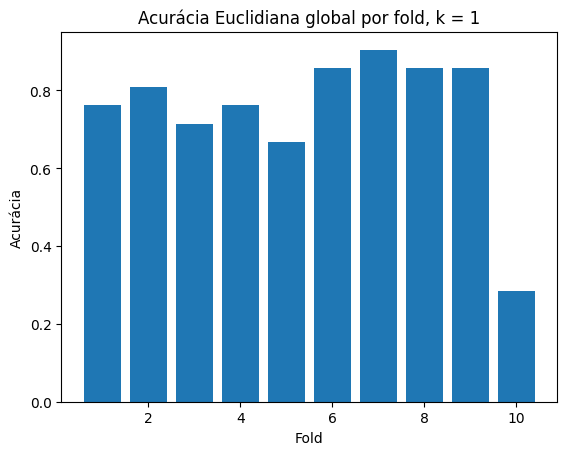

Acurácia global
Média: 0.7476190476190475
Desvio padrão: 0.1690979133768067


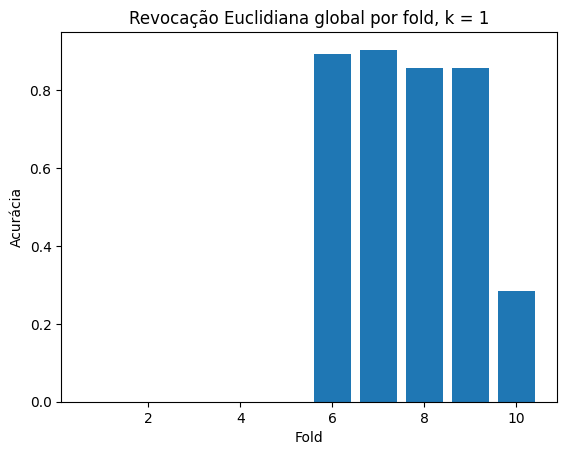

Revocação global
Média: 0.3799498746867168
Desvio padrão: 0.4155176839013757


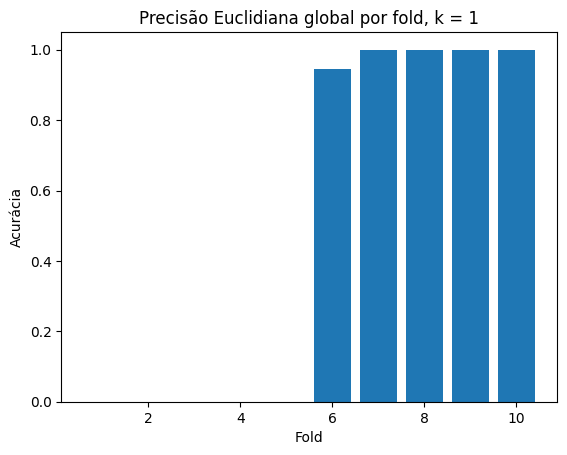

Precisão global
Média: 0.49444444444444446
Desvio padrão: 0.494694069321861


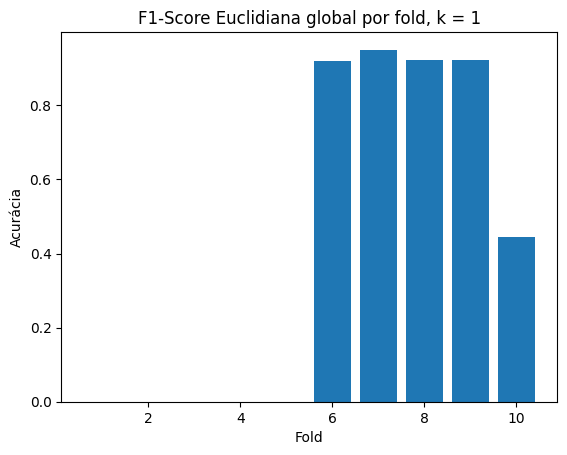

F1-Score global
Média: 0.4159517209517209
Desvio padrão: 0.437998460494096


In [1236]:
plot_graph(folds, acuracias, "Acurácia Euclidiana global por fold, k = 1")
print("Acurácia global")
print("Média:", np.mean(acuracias))
print("Desvio padrão:", np.std(acuracias))

plot_graph(folds, recalls, "Revocação Euclidiana global por fold, k = 1")
print("Revocação global")
print("Média:", np.mean(recalls))
print("Desvio padrão:", np.std(recalls))

plot_graph(folds, precisions, "Precisão Euclidiana global por fold, k = 1")
print("Precisão global")
print("Média:", np.mean(precisions))
print("Desvio padrão:", np.std(precisions))

plot_graph(folds, f1_scores, "F1-Score Euclidiana global por fold, k = 1")
print("F1-Score global")
print("Média:", np.mean(f1_scores))
print("Desvio padrão:", np.std(f1_scores))

In [1237]:
acuracias, recalls, precisions, f1_scores = validation(data, folds, num_classes, knn, distance_euclidiana, 5)

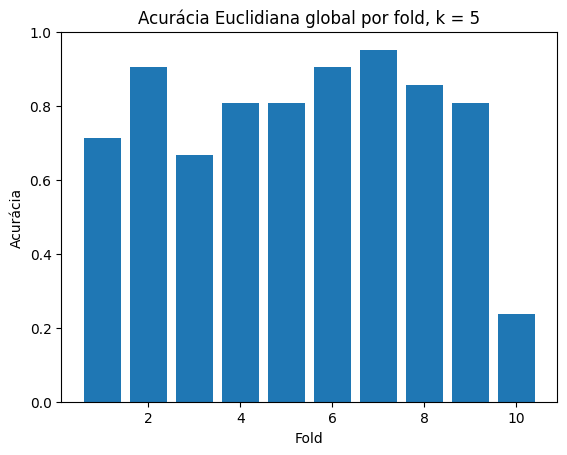

Acurácia global
Média: 0.7666666666666666
Desvio padrão: 0.19453998300776662


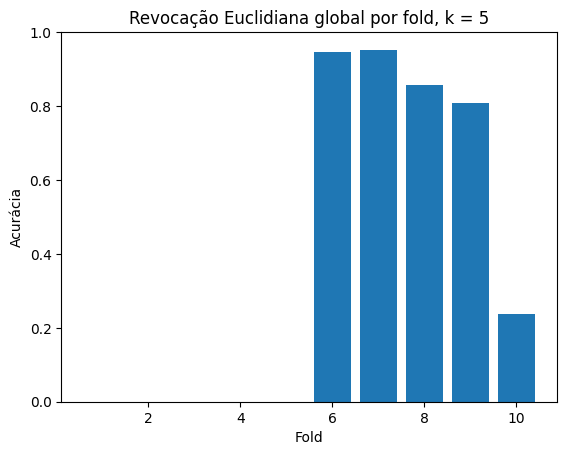

Revocação global
Média: 0.3804511278195489
Desvio padrão: 0.4247137642241806


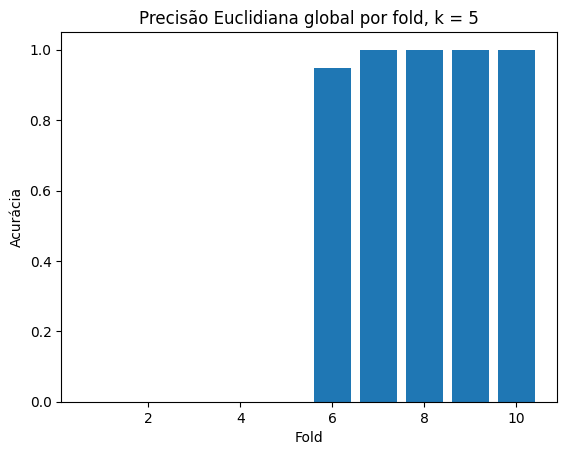

Precisão global
Média: 0.4947368421052632
Desvio padrão: 0.4949607556003683


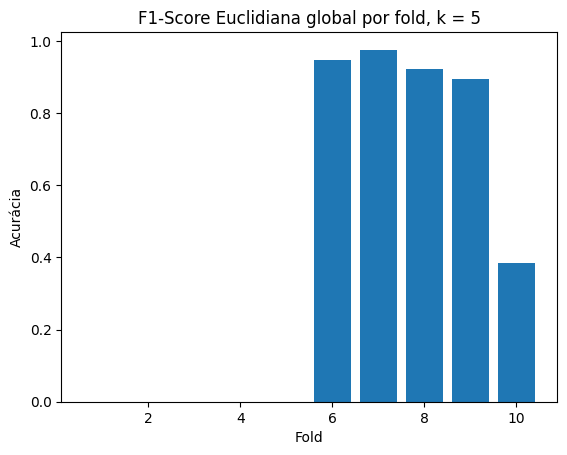

F1-Score global
Média: 0.4125407326947763
Desvio padrão: 0.44135889893572644


In [1238]:
plot_graph(folds, acuracias, "Acurácia Euclidiana global por fold, k = 5")
print("Acurácia global")
print("Média:", np.mean(acuracias))
print("Desvio padrão:", np.std(acuracias))

plot_graph(folds, recalls, "Revocação Euclidiana global por fold, k = 5")
print("Revocação global")
print("Média:", np.mean(recalls))
print("Desvio padrão:", np.std(recalls))

plot_graph(folds, precisions, "Precisão Euclidiana global por fold, k = 5")
print("Precisão global")
print("Média:", np.mean(precisions))
print("Desvio padrão:", np.std(precisions))

plot_graph(folds, f1_scores, "F1-Score Euclidiana global por fold, k = 5")
print("F1-Score global")
print("Média:", np.mean(f1_scores))
print("Desvio padrão:", np.std(f1_scores))

In [1239]:
acuracias, recalls, precisions, f1_scores = validation(data, folds, num_classes, knn, distance_mahalanobis, 1)

<ipython-input-1232-8a507fa56e3b>:7: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.mean(matrix, axis = 1))


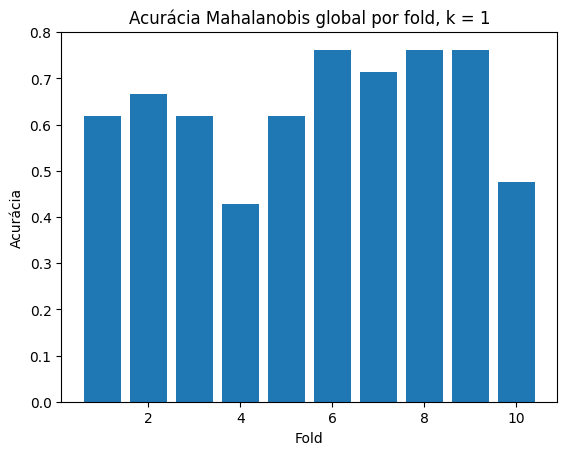

Acurácia global
Média: 0.6428571428571428
Desvio padrão: 0.11116778599932144


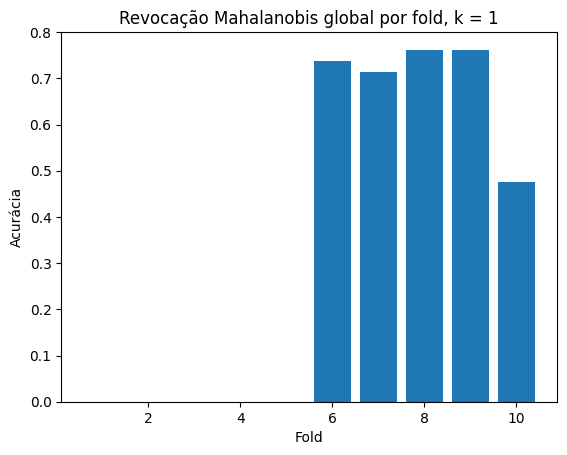

Revocação global
Média: 0.34511278195488726
Desvio padrão: 0.35353460213615534


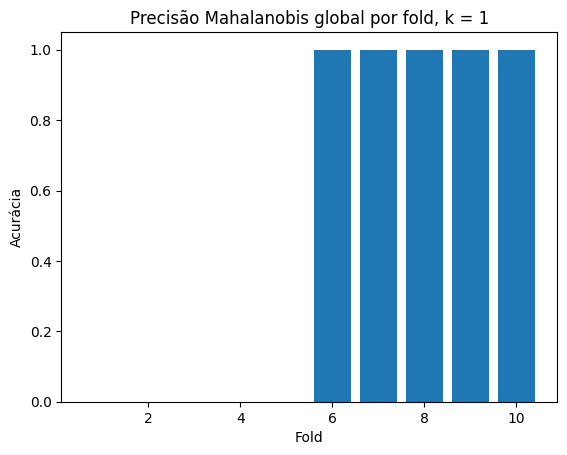

Precisão global
Média: 0.5
Desvio padrão: 0.5


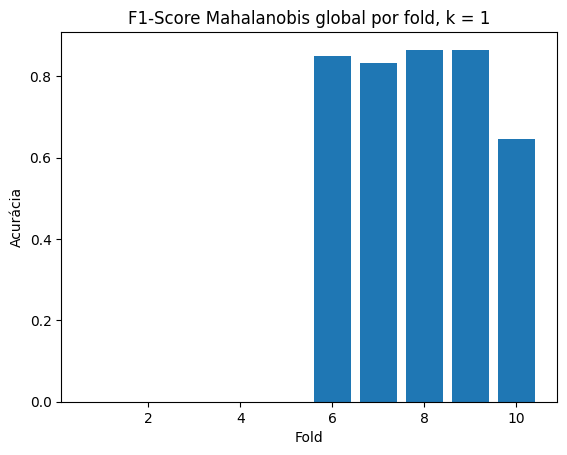

F1-Score global
Média: 0.40567092018704926
Desvio padrão: 0.40998751044207027


In [1240]:
plot_graph(folds, acuracias, "Acurácia Mahalanobis global por fold, k = 1")
print("Acurácia global")
print("Média:", np.mean(acuracias))
print("Desvio padrão:", np.std(acuracias))

plot_graph(folds, recalls, "Revocação Mahalanobis global por fold, k = 1")
print("Revocação global")
print("Média:", np.mean(recalls))
print("Desvio padrão:", np.std(recalls))

plot_graph(folds, precisions, "Precisão Mahalanobis global por fold, k = 1")
print("Precisão global")
print("Média:", np.mean(precisions))
print("Desvio padrão:", np.std(precisions))

plot_graph(folds, f1_scores, "F1-Score Mahalanobis global por fold, k = 1")
print("F1-Score global")
print("Média:", np.mean(f1_scores))
print("Desvio padrão:", np.std(f1_scores))

In [1241]:
acuracias, recalls, precisions, f1_scores = validation(data, folds, num_classes, knn, distance_mahalanobis, 5)

<ipython-input-1232-8a507fa56e3b>:7: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.mean(matrix, axis = 1))


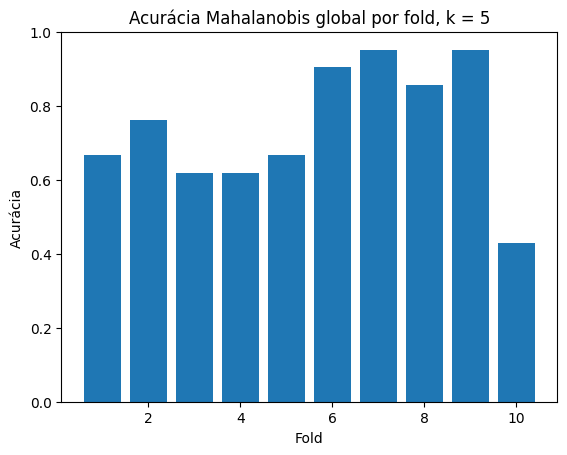

Acurácia global
Média: 0.7428571428571429
Desvio padrão: 0.16385381461033574


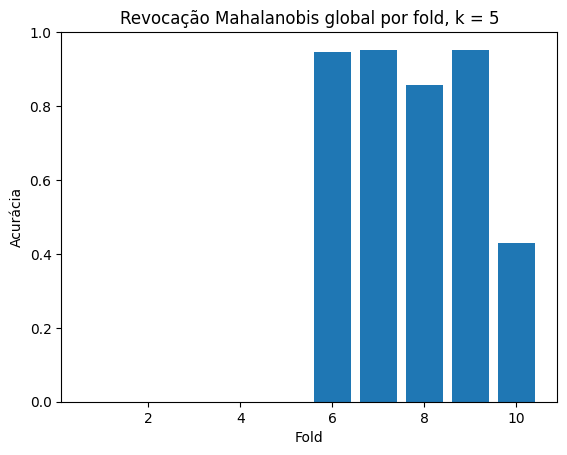

Revocação global
Média: 0.41378446115288214
Desvio padrão: 0.43792207367827674


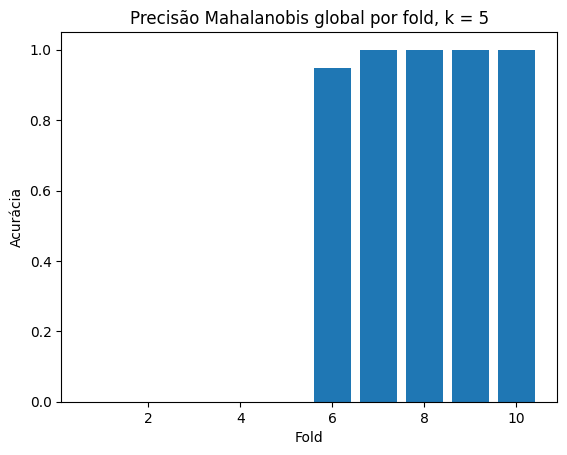

Precisão global
Média: 0.4947368421052632
Desvio padrão: 0.4949607556003683


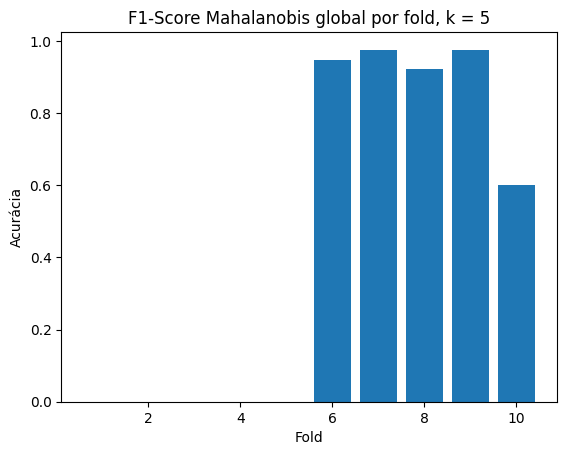

F1-Score global
Média: 0.4421664856324676
Desvio padrão: 0.45366228775871686


In [1242]:
plot_graph(folds, acuracias, "Acurácia Mahalanobis global por fold, k = 5")
print("Acurácia global")
print("Média:", np.mean(acuracias))
print("Desvio padrão:", np.std(acuracias))

plot_graph(folds, recalls, "Revocação Mahalanobis global por fold, k = 5")
print("Revocação global")
print("Média:", np.mean(recalls))
print("Desvio padrão:", np.std(recalls))

plot_graph(folds, precisions, "Precisão Mahalanobis global por fold, k = 5")
print("Precisão global")
print("Média:", np.mean(precisions))
print("Desvio padrão:", np.std(precisions))

plot_graph(folds, f1_scores, "F1-Score Mahalanobis global por fold, k = 5")
print("F1-Score global")
print("Média:", np.mean(f1_scores))
print("Desvio padrão:", np.std(f1_scores))

In [1243]:
acuracias, recalls, precisions, f1_scores = validation(data, folds, num_classes, tree, _, 1)

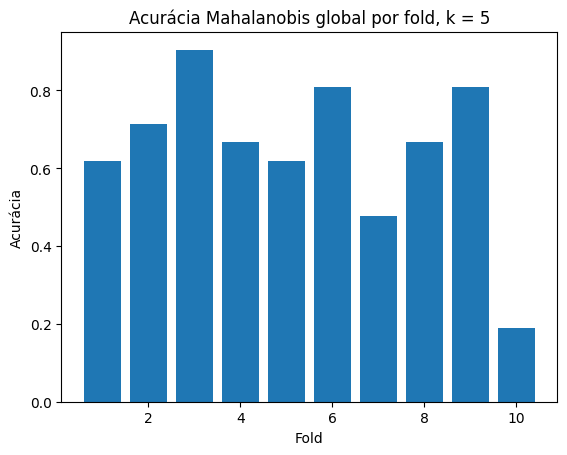

Acurácia global
Média: 0.6476190476190476
Desvio padrão: 0.19071413709048368


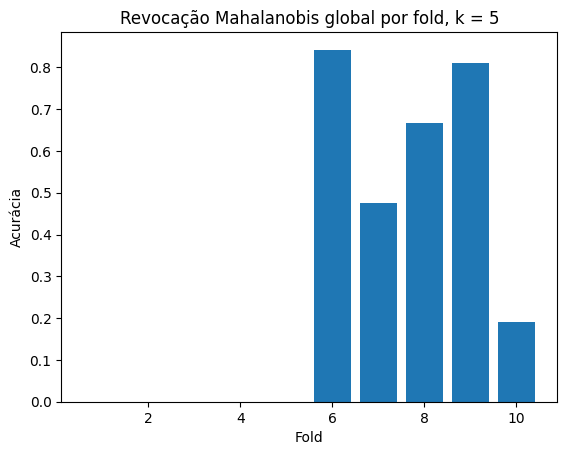

Revocação global
Média: 0.2984962406015038
Desvio padrão: 0.3436499685856437


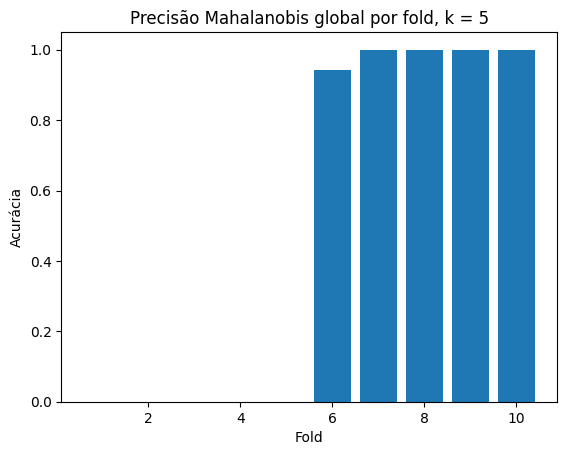

Precisão global
Média: 0.49411764705882355
Desvio padrão: 0.494397679751781


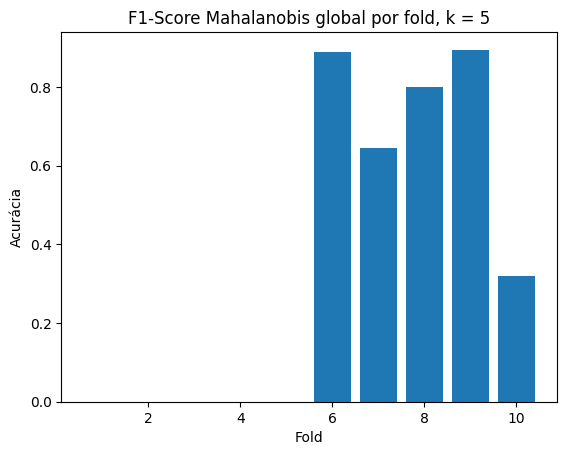

F1-Score global
Média: 0.3548787021316733
Desvio padrão: 0.38599502997768126


In [1244]:
plot_graph(folds, acuracias, "Acurácia Mahalanobis global por fold, k = 5")
print("Acurácia global")
print("Média:", np.mean(acuracias))
print("Desvio padrão:", np.std(acuracias))

plot_graph(folds, recalls, "Revocação Mahalanobis global por fold, k = 5")
print("Revocação global")
print("Média:", np.mean(recalls))
print("Desvio padrão:", np.std(recalls))

plot_graph(folds, precisions, "Precisão Mahalanobis global por fold, k = 5")
print("Precisão global")
print("Média:", np.mean(precisions))
print("Desvio padrão:", np.std(precisions))

plot_graph(folds, f1_scores, "F1-Score Mahalanobis global por fold, k = 5")
print("F1-Score global")
print("Média:", np.mean(f1_scores))
print("Desvio padrão:", np.std(f1_scores))